# ADAPTIVE SOBEL

## 1. Inti Masalah: Kenapa Perlu Adaptive Threshold?

- Sobel biasa pakai threshold manual buat nentuin apakah suatu piksel adalah edge atau bukan. Masalahnya:

- Threshold manual susah ditentukan.

- Setiap gambar bisa punya threshold yang berbeda karena faktor pencahayaan, noise, dll.

- Jadi, kalau threshold-nya salah, hasil edge detection jadi jelek.

📌 Solusi dari jurnal ini: Gunakan Genetic Algorithm (GA) untuk secara otomatis mencari threshold terbaik untuk gambar tertentu. Ini disebut adaptive thresholding.



## Konsep Genetic Algorithm (GA)

1. populasi acak
2. selection -> pilih treshlohd terbaik berdasar fitnes
3. crossover -> kombinasi dua treshold terbaik dan ambil tengahnya
4. mutation -> modifikasi dikit

Improved GA
- Crossover dan mutasi adaptif → tergantung nilai fitness.
- Threshold terbaik dicari dengan fungsi fitness berupa varian antar kelas maksimum (mirip Otsu's method).

**Langkah :**

1. Input gambar target.

2. GA mencari threshold optimal berdasarkan histogram gambar.

3. Threshold hasil GA digunakan pada Sobel untuk mendeteksi edge.

4. Output gambar hasil deteksi tepi.

**Hasil :**

- Bandingkan hasil deteksi tepi dengan Threshold manual (90, 120, 150, 180), Adaptive (hasil dari GA).

- Adaptive threshold memberi edge yang lebih jelas, halus, dan akurat.

- Menghindari masalah threshold manual yang bisa over-detect atau under-detect.


**IMPLEMENTTASI :**

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random


In [12]:
# 1. Fungsi bantu: fitness function pakai Otsu (σ² antar-kelas)

def calculate_fitness(img_gray, threshold):
    hist = cv2.calcHist([img_gray], [0], None, [256], [0,256]).flatten()
    total = img_gray.size
    prob = hist / total

    w0 = np.sum(prob[:threshold+1])
    w1 = np.sum(prob[threshold+1:])
    
    if w0 == 0 or w1 == 0:
        return 0  # avoid divide by zero

    mu0 = np.sum([i * prob[i] for i in range(0, threshold+1)]) / w0
    mu1 = np.sum([i * prob[i] for i in range(threshold+1, 256)]) / w1
    mu = np.sum([i * prob[i] for i in range(256)])

    sigma_b_squared = w0 * ((mu0 - mu) ** 2) + w1 * ((mu1 - mu) ** 2)
    return sigma_b_squared

In [13]:
# 2. Genetic Algorithm: cari threshold

def genetic_algorithm(img_gray, pop_size=10, generations=50):
    population = [random.randint(1, 254) for _ in range(pop_size)]

    for _ in range(generations):
        fitness_scores = [calculate_fitness(img_gray, t) for t in population]
        sorted_pop = [x for _, x in sorted(zip(fitness_scores, population), reverse=True)]
        
        # Selection: top 50% survive
        parents = sorted_pop[:pop_size // 2]

        # Crossover & Mutation
        children = []
        while len(children) < pop_size - len(parents):
            p1, p2 = random.sample(parents, 2)
            child = (p1 + p2) // 2  # simple single-point crossover
            # Mutasi kecil
            if random.random() < 0.3:
                child += random.randint(-5, 5)
                child = max(1, min(254, child))
            children.append(child)

        population = parents + children

    best_threshold = max(population, key=lambda t: calculate_fitness(img_gray, t))
    return best_threshold

In [14]:
# 3. Sobel Edge Detection pakai Threshold dari GA

def sobel_with_threshold(img_gray, threshold):
    sobelx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(sobelx, sobely)
    edges = (magnitude > threshold).astype(np.uint8) * 255
    return edges

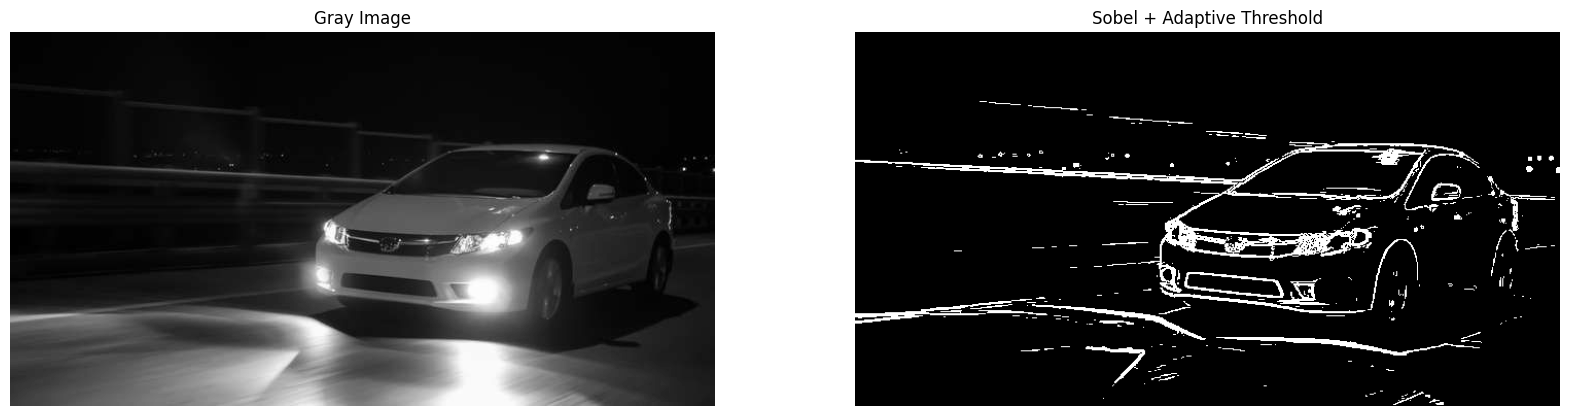

Adaptive threshold: 81


In [19]:
# 4. Uji Gambar

# Load & convert
img = cv2.imread("./assets/low_contrast.jpeg")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


# Deteksi edge
edge_result = sobel_with_threshold(img_gray, threshold)

plt.figure(figsize=(20, 10))

# Tampilkan hasil
plt.subplot(1, 2, 1)
plt.title("Gray Image")
plt.axis("off")
plt.imshow(img_gray, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Sobel + Adaptive Threshold")
plt.imshow(edge_result, cmap='gray')
plt.axis("off")
plt.show()


# Cari threshold terbaik
threshold = genetic_algorithm(img_gray)
print("Adaptive threshold:", threshold)


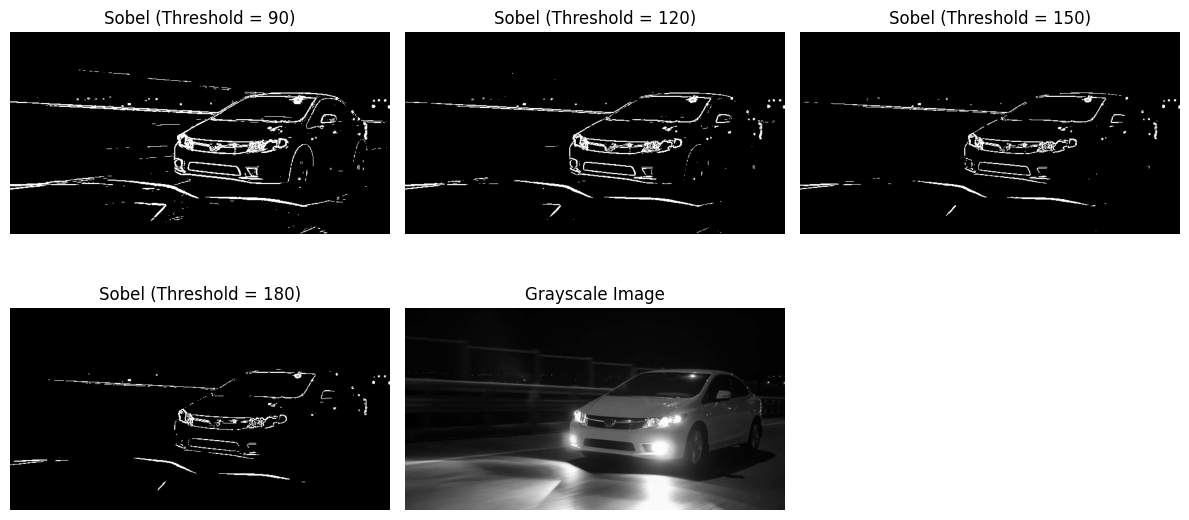

In [29]:
# Daftar threshold tetap
fixed_thresholds = [90, 120, 150, 180]

# Visualisasi perbandingan Sobel biasa
plt.figure(figsize=(12, 6))
for i, t in enumerate(fixed_thresholds):
    edge_result = sobel_with_threshold(img_gray, t)
    plt.subplot(2, 3, i+1)
    plt.imshow(edge_result, cmap='gray')
    plt.title(f"Sobel (Threshold = {t})")
    plt.axis('off')

# Tampilkan juga grayscale original di posisi pertama
plt.subplot(2, 3, 5)
plt.imshow(img_gray, cmap='gray')
plt.title("Grayscale Image")
plt.axis('off')

plt.tight_layout()
plt.show()